## Inference with the model on openEO

This notebook demonstrates how to use a trained model for inference with onnxruntime in an udf.

In [1]:
import openeo
from features import preprocess_features

from rasterio.plot import show
import rasterio

In [15]:
# Test parameters
bbox = {"west": 5.0, "south": 51.2, "east": 5.02, "north": 51.22}
temporal_extent = ("2018-01-01", "2018-12-31")

# Setup the connection
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

The feature extraction is the same as the training notebook and is defined in a [seperate python file](./features.py). It expects an S1 and S2 datacube.

In [3]:
# Load S1 and S2 collections
s1 = connection.load_collection(
    "SENTINEL1_GRD",
    spatial_extent= bbox,
    temporal_extent=temporal_extent,
    bands=["VH", "VV"],
).sar_backscatter( # GFMap performed this step in the extraction
    coefficient="sigma0-ellipsoid"
)
s2 = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent= bbox,
    temporal_extent=temporal_extent,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12", "SCL"],
    max_cloud_cover=80
)

# Preprocess the features
features = preprocess_features(s2_datacube=s2, s1_datacube=s1)

The pre-trained model can be directly applied to the resulting datacube.

The model is loaded with onnxruntime in [this udf](./udf_rf_onnx.py). It requires the onnxruntime package as an archive and the model file.

Make sure to upload your model to a publicly available location, such as a cloud storage service. The file has to be downloadable with e.g. wget, so only a direct download link will work.

In [22]:
# Supply the model as a URL and create an UDF from a file
from numpy import uint8


model_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/grasslandwatch/lc_offline/random_forest.onnx"
udf = openeo.UDF.from_file(
    "udf_rf_onnx.py", 
    context={
        "model_url": model_url
    }
)

# Reduce the bands dimesnion to a single prediction using the udf
prediction = features.reduce_bands(reducer=udf)
# This step ensures the datatype is unint8
prediction = prediction.linear_scale_range(0.0,8.0,0,8)

# Add the onnx dependencies to the job options. You can reuse this existing dependencies archive
dependencies_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/onnx_dependencies_1.16.3.zip"
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps"
    ],
}

prediction_job = prediction.create_job(
    out_format="GTiff",
    job_options=job_options,
    title="LC_prediction"
)
prediction_job.start_and_wait()

0:00:00 Job 'j-240327d48fe54e52ac91286e0e354a93': send 'start'
0:00:14 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:00:19 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:00:26 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:00:34 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:00:45 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:00:57 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:01:15 Job 'j-240327d48fe54e52ac91286e0e354a93': queued (progress N/A)
0:01:34 Job 'j-240327d48fe54e52ac91286e0e354a93': running (progress N/A)
0:01:58 Job 'j-240327d48fe54e52ac91286e0e354a93': running (progress N/A)
0:02:28 Job 'j-240327d48fe54e52ac91286e0e354a93': running (progress N/A)
0:03:06 Job 'j-240327d48fe54e52ac91286e0e354a93': running (progress N/A)
0:03:53 Job 'j-240327d48fe54e52ac91286e0e354a93': running (progress N/A)
0:04:54 Job 'j-240327d48fe54e52ac91286e0e354a93': running (progress 

<BatchJob job_id='j-240327d48fe54e52ac91286e0e354a93'>

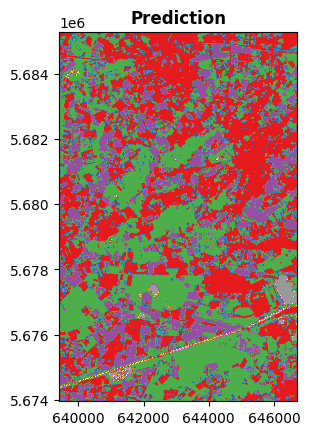

In [23]:
result_path = "output/predictions/prediction.tiff"
prediction_job.download_result(result_path)

with rasterio.open(result_path, dtype="uint8") as src:
    show(src, title="Prediction", cmap="Set1")